# Тестовое задание в команду Data Science IDP

Импорт библиотек

In [77]:
import pandas as pd

import os
import pathlib
import re

from typing import List, Tuple

## Формулировка задания

**Написать решение по извлечению сущностей из документов (новостных текстов)**

**Датасет** -- семпл текстов с аннотациями русских новостей (источник: https://bsnlp.cs.helsinki.fi/bsnlp-2019/shared_task.html)

**Интересующие сущности:**
- *PER* - persons (личности)
- *ORG* - organizations (организации)
- *LOC* - locations (места)
- *EVT* - events (события)
- *PRO* - products (продукты и документы)

Достаточно использовать *9 документов* про *брекзит* из семпла

## Задание 1 (Анализ задачи)

**Описание задачи с точки зрения NLP**

Это задача извлечения именованных сущностей из текст -- *Named Entity Recognition (NER)*. В данном случае мы занимаемся последовательной разметкой, классифицируя каждый токен как PER, ORG, LOC, EVT, PRO или не являющийся сущностью

**Классические методы решения:**
- Статистические методы: *Условные случайные поля (CRF)*, *Марковская модель максимальной энтропии (MEMM)*
- Рекуррентные нейронные сети: *LSTM*, *BiLSTM* (часто с CRF слоем)
- Энкодерные трансформеры: *BERT-like*

**LLM методы:**
- *Zero-shot/Few-shot* подходы (GPT, в т.ч. *GigaChat*)
- Промты с инструкциями для GPT-моделей
- *Fine-tuning* на обучающей выборке
- *Chain-of-Thought (CoT)* промпты для размышления перед определением сущности

**Метрики качества:**
- *Precision, Recall и F1-score* для найденных сущностей (верные границы), **без учета типа сущности**
- *Precision, Recall и F1-score* для **точного совпадения** (границы + тип сущности)
- Эти же метрики с *частичным совпадением границ*
- Эти же метрики для каждого отдельного класса (для выявления, с какими типами сущностей у модели проблемы). Macro-F1 (усреднённый по классам)

- Можно добавить *accuracy* лемматизации каждой верно найденной сущности (для задачи из оригинального соревнования)
- *Inference time* (в данном случае зависит от провайдера GigaChat)

## Задание 2 (Формирование DataFrame)

### Чтение датасета в pandas DataFrame с обязательными колонками "document_id", "document_text", "entity", "gold_answer"

#### Функция для извлечения данных и формирования DataFrame

In [78]:
def read_bsnlp_data(data_dir: str='sample_pl_cs_ru_bg', lang: str="ru") -> pd.DataFrame:
    """
    Считывание данных соревнования из папок raw/ru и annotated/ru и преобразует в
    требуемый формат pd.DataFrame: ["document_id", "document_text", "entity", "gold_answer"]
    """
    raw_dir = pathlib.Path(data_dir) / 'raw' / lang
    annotated_dir = pathlib.Path(data_dir) / 'annotated' / lang

    documents_desc: List[dict] = []

    # Raw файлы
    for raw_file in raw_dir.glob('*.txt'):
        with open(raw_file, encoding="utf-8") as f:
            lines: List[str] = f.readlines()

        assert len(lines) >= 5, f"File \"{str(raw_file)}\" contains less than 5 lines"

        document_id = lines[0].strip()
        language = lines[1].strip()
        date = lines[2].strip()
        url = lines[3].strip()
        title = lines[4].strip()
        content = ' '.join([line.strip() for line in lines[5:] if line.strip()])
        document_text = title + ' ' + content

        # Ищем соответствующий аннотированный файл
        annotation_file = annotated_dir / f"{raw_file.stem}.out"

        assert annotation_file.exists(), \
            f"Annotation file \"{str(annotation_file)}\" corresponding to raw file \"{str(raw_file)}\" does not exist"
        
        # Читаем аннотации
        with open(annotation_file, encoding='utf-8') as f:
            annotation_lines = f.readlines()

        assert len(annotation_lines) > 0, f"Annotation file \"{str(annotation_file)}\" is empty"
        annotation_doc_id = annotation_lines[0].strip()

        assert document_id == annotation_doc_id, "Raw and Annotated doc ids do not match: " \
                                                f"{document_id}, {annotation_doc_id}"

        entities_found = []

        for line in annotation_lines[1:]:
            line = line.strip()
            if line:
                columns = line.split('\t')
                assert len(columns) == 4

                entity_text, entity_text_lemmatized, entity_type, entity_id = columns

                entities_found.append( (entity_text, entity_type) )
        
        for entity_text, entity_type in entities_found:
            documents_desc.append({
                'document_id': document_id,
                'document_text': document_text,
                'entity': entity_text,
                'gold_answer': entity_type
            })
        if not entities_found:
            documents_desc.append({
                'document_id': document_id,
                'document_text': document_text,
                'entity': None,
                'gold_answer': None
            })
        
    return pd.DataFrame(documents_desc)


#### Просмотр данных

In [79]:
df = read_bsnlp_data()
df.head()

,document_id,document_text,entity,gold_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit,EVT
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбиона,LOC
2,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбионе,LOC
3,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Борис Джонсон,PER
4,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британии,LOC


## Задание 3 (Функция для преобразования строки из DataFrame в запрос для LLM)

In [80]:
def create_prompt_for_llm(row: pd.Series) -> str:
    """
    Создает промпт для LLM на основе строки датафрейма
    """
    document_text = row['document_text']
    
    prompt = f"""Извлеки из **текста для анализа** все (необязательно уникальные) именованные сущности и классифицируй их по типам, опираясь на контекст и нижеуказанные инструкции.

**Типы сущностей:**
- PER (persons) - личности, имена людей (без прилежащих титулов), группы людей ("русские"; НО НЕ "мусульмане", т.к. нет конкретной объединяющей организации)
- ORG (organizations) - организации, компании, учреждения, объединения
- LOC (locations) - географические места, страны, города
- EVT (events) - события, процессы, явления
- PRO (products) - продукты, документы, произведения

**Если равновероятными кажутся типы:**
- ORG и PER, то должно быть выбрано PER;
- ORG и PRO, то должно быть выбрано ORG.

**Замечания:**
- Сохраняй точную форму, регистр слов и количество вхождений сущностей как в оригинальном тексте. 
То есть, если сущность встречается в нескольких формах (Москва, Москвы), каждая форма должна быть в ответе.
Однако одинаковые формы (Москва, Москва) повторять не надо.
- Текст "Премьер-министр Великобритании Тереза Мэй" содержит LOC (Великобритании) и PER (Тереза Мэй)
- Текст "Церковь Св. Стефана в Стамбуле" является целиком одной сущностью типа LOC
- Расположение организации ORG и события EVT является частью их сущности ("Сберанк в Москве" - ORG, "Олимпиада 2014 в Сочи" - EVT)
- Если событие так же является местом ("Он погиб в Сталинграде, незадолго до битвы"), то выбирается тип LOC

**Текст для анализа:**
{document_text}

**Формат ответа:**
Перечисли найденные сущности в формате:
- [Название сущности] -- [Тип];

Пример:
- Борис Джонсон -- PER;
- Британия -- LOC;
- Британии -- LOC;
- Brexit -- EVT"""

    return prompt

In [81]:
# Тестируем функцию на первой строке
test_row = df.iloc[0]
test_prompt = create_prompt_for_llm(test_row)
print("Пример промпта для первой строки:")
print("="*50)
print(test_prompt)
print("="*50)


Пример промпта для первой строки:
Извлеки из **текста для анализа** все (необязательно уникальные) именованные сущности и классифицируй их по типам, опираясь на контекст и нижеуказанные инструкции.

**Типы сущностей:**
- PER (persons) - личности, имена людей (без прилежащих титулов), группы людей ("русские"; НО НЕ "мусульмане", т.к. нет конкретной объединяющей организации)
- ORG (organizations) - организации, компании, учреждения, объединения
- LOC (locations) - географические места, страны, города
- EVT (events) - события, процессы, явления
- PRO (products) - продукты, документы, произведения

**Если равновероятными кажутся типы:**
- ORG и PER, то должно быть выбрано PER;
- ORG и PRO, то должно быть выбрано ORG.

**Замечания:**
- Сохраняй точную форму, регистр слов и количество вхождений сущностей как в оригинальном тексте. 
То есть, если сущность встречается в нескольких формах (Москва, Москвы), каждая форма должна быть в ответе.
Однако одинаковые формы (Москва, Москва) повторять не 

## Задание 4 (Получение и сохранение ответов от GigaChat)

### Функции для реализации интерфейса в jupyter-notebook

In [82]:
class Metrics:
    """
    Некоторые метрики (в основном для подсчёта сходства по Левенштейну)
    """
    @staticmethod
    def extract_entity(label: str) -> str | None:
        """
        Извлечение сущности из строки метки

        Args:
            label (str | None): метка, строка вида "entity|type"
        Returns:
            entity (str | None): строка сущности
        """
        if pd.isna(label):
            return None
        return label.split('|')[0] if '|' in label else None
    
    @staticmethod
    def extract_type(label: str) -> str | None:
        """
        Извлечение типа сущности из строки метки

        Args:
            label (str | None): метка, строка вида "entity|type"
        Returns:
            type (str | None): строка типа сущности
        """
        if pd.isna(label):
            return None
        return label.split('|')[1] if '|' in label else None

    @staticmethod
    def levenshtein_distance(s1: str, s2: str) -> float:
        """
        Вычисляет модифицированное расстояние Левенштейна между двумя строками
        (несовпадение регистра даёт штраф 0.5)
        
        Args:
            s1 (str): первая строка
            s2 (str): вторая строка
        Returns:
            distance (float): минимальное количество операций (вставка, удаление, замена)
                для преобразования s1 в s2. Смена регистра стоит 0.5 вместо 1.0
        """

        if len(s1) < len(s2):
            return Metrics.levenshtein_distance(s2, s1)
        
        if len(s2) == 0:
            return len(s1)
        
        # Динамическое программирование
        previous_row = list(range(len(s2) + 1))
        for i, c1 in enumerate(s1):
            current_row = [i + 1.]
            for j, c2 in enumerate(s2):
                # Стоимость операций
                insertions = previous_row[j + 1] + 1.      # вставка
                deletions = current_row[j] + 1.            # удаление

                if c1 == c2:
                    cost = 0.
                elif c1.lower() == c2.lower():  # Разный регистр
                    cost = 0.5
                else:
                    cost = 1.0

                substitutions = previous_row[j] + cost  # замена
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row
        
        return previous_row[-1]
    
    @staticmethod
    def partial_match_levenshtein(gold: str, pred: str) -> float:
        """
        Частичное совпадение границ и формы сущности (расстояние Левенштейна),
        без учёта типа
    
        Args:
            gold (str | None): истинное значение, строка вида "entity|type"
            pred (str | None): предсказанное значение, строка вида "entity|type"
        Returns:
            score (float): нормализованное сходство от 0.0 до 1.0, где:
                1.0 - полное сходство сущностей
                0.0 - полное несовпадение
        """
        if pd.isna(gold) and pd.isna(pred):
            return 1.
        if pd.isna(gold) or pd.isna(pred):
            return 0.
        
        # Извлечение сущностей
        gold_entity: str = Metrics.extract_entity(gold)  # type: ignore
        pred_entity: str = Metrics.extract_entity(pred)  # type: ignore

        if None in (gold_entity, pred_entity):
            raise ValueError(f"Gold ({gold_entity}) or prediction ({pred_entity}) has wrong format or None")
        
        if gold_entity == pred_entity:
            return 1.
        
        # Вычисляем расстояние Левенштейна
        distance = Metrics.levenshtein_distance(gold_entity, pred_entity)
        max_len = max(len(gold_entity), len(pred_entity))

        # Нормализованное расстояние
        return max(0., 1. - distance / max_len)


In [83]:
def smart_entity_matching(llm_entities: List[Tuple[str, str]], 
                         gold_entities: List[str], 
                         threshold: float = 0.5) -> List[Tuple[int, str, str, float]]:
    """
    Умное сопоставление LLM сущностей с золотым стандартом по сходству Левенштейна
    
    Returns:
        List[Tuple[gold_index, llm_entity, llm_type, similarity_score]]
    """
    
    matches = []
    used_gold_indices = set()
    
    for llm_entity, llm_type in llm_entities:
        best_match = None
        best_score = 0.0
        best_gold_idx = -1
        
        # Ищем лучшее совпадение среди неиспользованных золотых сущностей
        for gold_idx, gold_entity in enumerate(gold_entities):
            if gold_idx in used_gold_indices:
                continue
                
            # Вычисляем сходство только по entity (без типа)
            similarity = Metrics.partial_match_levenshtein(
                f"{gold_entity}|DUMMY", f"{llm_entity}|DUMMY"
            )
            
            if similarity > best_score and similarity >= threshold:
                best_score = similarity
                best_match = gold_entity
                best_gold_idx = gold_idx
        
        if best_match is not None:
            matches.append((best_gold_idx, llm_entity, llm_type, best_score))
            used_gold_indices.add(best_gold_idx)
        else:
            # Новая сущность от LLM
            matches.append((-1, llm_entity, llm_type, 0.0))
    
    return matches


def split_text_into_chunks(text: str, max_words: int = 300) -> List[str]:
    """
    Разбивает текст на части по предложениям
    """
    sentences = text.split('.')
    chunks = []
    current_chunk = ""
    
    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue
            
        # Проверяем, не превысит ли добавление предложения лимит
        test_chunk = current_chunk + ". " + sentence if current_chunk else sentence
        if len(test_chunk.split()) <= max_words:
            current_chunk = test_chunk
        else:
            if current_chunk:
                chunks.append(current_chunk + ".")
            current_chunk = sentence
    
    if current_chunk:
        chunks.append(current_chunk + ".")
    
    return chunks


def get_llm_response_interface(df: pd.DataFrame) -> pd.DataFrame:
    """
    Интерфейс для получения ответов от LLM и сохранения результатов
    """
    # Создаем копию DataFrame и добавляем новые колонки
    result_df = df.copy()
    result_df['llm_entity'] = None
    result_df['llm_answer'] = None
    
    # Получаем уникальные документы для обработки
    unique_docs = df['document_id'].unique()
    
    print(f"Найдено {len(unique_docs)} уникальных документов для обработки:")
    print(list(unique_docs))
    
    return result_df


def parse_llm_response(response: str) -> List[Tuple[str, str]]:
    """
    Парсит ответ LLM и возвращает список (entity, type)
    """
    entities = []
    lines = response.strip().split(';')
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
            
        # Убираем тире в начале
        if line.startswith('-'):
            line = line[1:].strip()
            
        # Ищем паттерн "сущность -- тип"
        if ' -- ' in line:
            parts = line.split(' -- ', 1)
            if len(parts) == 2:
                entity = parts[0].strip()
                entity_type = parts[1].strip()
                if entity and entity_type:
                    entities.append((entity, entity_type))
    
    return entities


def process_document_chunked(doc_id: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Обрабатывает один документ по частям с умным сопоставлением сущностей
    """
    # Получаем строки для данного документа
    doc_rows = df[df['document_id'] == doc_id]
    if doc_rows.empty:
        raise Exception(f"Документ {doc_id} не найден!")
    
    first_row = doc_rows.iloc[0]
    document_text = first_row['document_text']
    
    # Разбиваем текст на части
    chunks = split_text_into_chunks(document_text, max_words=250)
    
    print(f"Документ {doc_id} разбит на {len(chunks)} частей")
    
    all_llm_entities = []
    
    for i, chunk in enumerate(chunks, 1):
        print(f"\n--- ЧАСТЬ {i}/{len(chunks)} ---")
        
        # Создаем временную строку для части текста
        chunk_row = first_row.copy()
        chunk_row['document_text'] = chunk
        
        prompt = create_prompt_for_llm(chunk_row)
        
        print("ПРОМПТ:")
        print("-" * 40)
        print(prompt)
        print("-" * 40)
        
        print(f"\nВведите ответ для части {i} (пустая строка для завершения):")
        
        llm_response_lines = []
        while True:
            line = input()
            if line.strip() == '':
                break
            llm_response_lines.append(line)
        
        if llm_response_lines:
            llm_response = '\n'.join(llm_response_lines)
            chunk_entities = parse_llm_response(llm_response)
            all_llm_entities.extend(chunk_entities)
    
    # Удаляем дубликаты
    unique_entities = []
    seen = set()
    for entity, entity_type in all_llm_entities:
        entity_key = (entity.lower(), entity_type)
        if entity_key not in seen:
            unique_entities.append((entity, entity_type))
            seen.add(entity_key)
    
    print(f"\nОбъединенный результат: {len(unique_entities)} уникальных сущностей")
    
    # Получаем золотые сущности для данного документа
    gold_entities_data = doc_rows[doc_rows['entity'].notna()]
    gold_entities_list = gold_entities_data['entity'].tolist()
    
    print(f"Золотых сущностей в документе: {len(gold_entities_list)}")
    
    # УМНОЕ СОПОСТАВЛЕНИЕ вместо точного поиска
    matches = smart_entity_matching(unique_entities, gold_entities_list, threshold=0.6)
    
    new_rows = []
    matched_count = 0
    
    print("\n=== РЕЗУЛЬТАТЫ СОПОСТАВЛЕНИЯ ===")
    
    for gold_idx, llm_entity, llm_type, similarity in matches:
        if gold_idx >= 0:  # Найдено совпадение с золотым стандартом
            gold_entity = gold_entities_list[gold_idx]
            
            # Обновляем соответствующую строку в DataFrame
            mask = (df['document_id'] == doc_id) & (df['entity'] == gold_entity)
            df.loc[mask, 'llm_entity'] = llm_entity
            df.loc[mask, 'llm_answer'] = llm_type
            matched_count += 1
            
            print(f"Сопоставлено: '{gold_entity}' ↔ '{llm_entity}' (сходство: {similarity:.3f})")
        else:
            # Новая сущность от LLM (не найдено совпадения)
            new_row = {
                'document_id': doc_id,
                'document_text': first_row['document_text'],
                'entity': None,
                'gold_answer': None,
                'llm_entity': llm_entity,
                'llm_answer': llm_type
            }
            new_rows.append(new_row)
            
            print(f"Новая сущность: '{llm_entity}' ({llm_type})")
    
    # Проверяем, какие золотые сущности остались без сопоставления
    matched_gold_indices = {match[0] for match in matches if match[0] >= 0}
    unmatched_gold = [
        gold_entities_list[i] for i in range(len(gold_entities_list)) 
        if i not in matched_gold_indices
    ]
    
    if unmatched_gold:
        print(f"\nПропущенные золотые сущности: {unmatched_gold}")
    
    print(f"\nРезультат сохранен для документа {doc_id}")
    print(f"LLM нашла: {len(unique_entities)} сущностей")
    print(f"Умных совпадений: {matched_count}")
    print(f"Новых сущностей от LLM: {len(new_rows)}")
    print(f"Пропущенных золотых сущностей: {len(unmatched_gold)}")
    print("="*80)

    # Добавляем новые строки для сущностей, найденных только LLM
    if new_rows:
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)
    
    return df


def process_all_documents(df: pd.DataFrame) -> pd.DataFrame:
    """
    Последовательно обрабатывает все документы
    """
    unique_docs = df['document_id'].unique()
    
    print(f"Начинаем обработку {len(unique_docs)} документов...")
    print("Для каждого документа будет показан промпт, который нужно отправить в LLM")
    print("Затем введите полученный ответ")
    print("\n")
    
    for i, doc_id in enumerate(unique_docs, 1):
        print(f"\n[{i}/{len(unique_docs)}]")
        df = process_document_chunked(doc_id, df)
        
        if i < len(unique_docs):
            ans = input(f"\nПродолжить с документом {i+1}? (y/n): ").strip().lower()
            if ans.lower() != 'y':
                print("Обработка остановлена.")
                break
    
    return df


### Печать пропмтов и получение ответов GigaChat

In [84]:
# Инициализируем DataFrame для работы
result_df = get_llm_response_interface(df)

Найдено 9 уникальных документов для обработки:
['ru-10', 'ru-1000', 'ru-1001', 'ru-1002', 'ru-1003', 'ru-1004', 'ru-1006', 'ru-1011', 'ru-1017']


In [85]:
result_df = process_all_documents(result_df)

Начинаем обработку 9 документов...
Для каждого документа будет показан промпт, который нужно отправить в LLM
Затем введите полученный ответ



[1/9]
Документ ru-10 разбит на 3 частей

--- ЧАСТЬ 1/3 ---
ПРОМПТ:
----------------------------------------
Извлеки из **текста для анализа** все (необязательно уникальные) именованные сущности и классифицируй их по типам, опираясь на контекст и нижеуказанные инструкции.

**Типы сущностей:**
- PER (persons) - личности, имена людей (без прилежащих титулов), группы людей ("русские"; НО НЕ "мусульмане", т.к. нет конкретной объединяющей организации)
- ORG (organizations) - организации, компании, учреждения, объединения
- LOC (locations) - географические места, страны, города
- EVT (events) - события, процессы, явления
- PRO (products) - продукты, документы, произведения

**Если равновероятными кажутся типы:**
- ORG и PER, то должно быть выбрано PER;
- ORG и PRO, то должно быть выбрано ORG.

**Замечания:**
- Сохраняй точную форму, регистр слов и коли

### Сохранение/Загрузка Датафрейма

In [86]:
def save_results(df: pd.DataFrame, filename: str = 'llm_results_df'):
    """Сохраняет результаты в нескольких форматах"""
    df.to_pickle(f'{filename}.pkl')
    df.to_csv(f'{filename}.csv', index=False, encoding='utf-8')
    print(f"Результаты сохранены как {filename}.pkl и {filename}.csv")


def load_results(filename: str = 'llm_results_df') -> pd.DataFrame:
    """Загружает сохраненные результаты"""
    try:
        df = pd.read_pickle(f'{filename}.pkl')
        print(f"Загружен {filename}.pkl")
        return df
    except FileNotFoundError:
        try:
            df = pd.read_csv(f'{filename}.csv', encoding='utf-8')
            print(f"Загружен {filename}.csv")
            return df
        except FileNotFoundError:
            raise FileNotFoundError(f"Файлы {filename}.pkl или {filename}.csv не найдены")

In [93]:
# save_results(result_df)
results_df = load_results()

Загружен llm_results_df.pkl


### Просмотр результатов

In [94]:
result_df.head(10)

,document_id,document_text,entity,gold_answer,llm_entity,llm_answer
0,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Brexit,EVT,Brexit,EVT
1,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбиона,LOC,Альбион,LOC
2,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Альбионе,LOC,None,None
3,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Борис Джонсон,PER,Борис Джонсон,PER
4,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британии,LOC,Британии,LOC
5,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Британия,LOC,Британия,LOC
6,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселе,LOC,None,None
7,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселем,LOC,None,None
8,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюссель,LOC,Брюссель,LOC
9,ru-10,Тереза Мэй рассчитывает усидеть в седле до зав...,Брюсселю,LOC,None,None


## Задание 5 (Подсчёт метрик)

**Основная метрика** (score_fn) - взевешенная комбинация между схожестью найденной сущности с эталонной и верной классификацией типа сущности. 

При чём точность классификации в 1.5 раза важнее верного строкового представления сущности типа (вес 0.6 против 0.4). В целом GPT находит строковые представления без сильных искажений, поэтому верной классификации уделяется немного больше внимания.

Часто модель лемматизирует слова ("Москва" вместо "Москвы" как в исходном тексте), верно классифицируя сущность. Такие случаи будут получать близкую к 1.0 оценку (в указанном примере ~0.93). 

При этом не сильное искажение сущности, ни неверный тип не должны полностью обнулять метрику.

### Класс для подсчёта метрик

In [89]:
import numpy as np
import pandas as pd


class NERMetrics(Metrics):
    """
    Класс для вычисления метрик качества распознавания сущностей
    """
    @staticmethod
    def exact_match_score(gold: str, pred: str) -> float:
        """
        Точное совпадение сущности и типа

        Args:
            gold (str | None): истинное значение, строка вида "entity|type"
            pred (str | None): предсказанное значение, строка вида "entity|type"
        Returns:
            score (float): 1.0 если точное совпадение, 0.0 иначе
        """
        if pd.isna(gold) and pd.isna(pred):
            return 1.
        if pd.isna(gold) or pd.isna(pred):
            return 0.
        return 1. if gold == pred else 0.
    
    @staticmethod
    def boundary_match_score(gold: str, pred: str) -> float:
        """
        Совпадение границ и формы сущности без учёта типа
        
        Args:
            gold (str | None): истинное значение, строка вида "entity|type"
            pred (str | None): предсказанное значение, строка вида "entity|type"
        Returns:
            score (float): 1.0 если строки одинаковы, 0.0 иначе
        """
        if pd.isna(gold) and pd.isna(pred):
            return 1.
        if pd.isna(gold) or pd.isna(pred):
            return 0.
        
        # Извлечение сущностей
        gold_entity = NERMetrics.extract_entity(gold)
        pred_entity = NERMetrics.extract_entity(pred)

        if None in (gold_entity, pred_entity):
            raise ValueError(f"Gold ({gold_entity}) or prediction ({pred_entity}) has wrong format or None")
        
        return 1. if gold_entity == pred_entity else 0.
    
    @staticmethod
    def type_accuracy_score(gold: str, pred: str) -> float:
        """
        Точность типа (совпадение или нет)

        Args:
            gold (str | None): истинное значение, строка вида "entity|type"
            pred (str | None): предсказанное значение, строка вида "entity|type"
        Returns:
            score (float): 1.0 если типы совпадают, 
                          0.0 если типы не совпадают
        """

        if pd.isna(gold) and pd.isna(pred):
            return 1.
        if pd.isna(gold) or pd.isna(pred):
            return 0.
        
        gold_type = NERMetrics.extract_type(gold)
        pred_type = NERMetrics.extract_type(pred)

        if None in (gold_type, pred_type):
            raise ValueError(f"Gold ({gold_type}) or prediction ({pred_type}) has wrong format or None")

        return 1. if gold_type == pred_type else 0.
    
    @staticmethod
    def compute_precision_recall_f1(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
        """
        Вычисляет precision, recall и F1-score

        Args:
            tp: True Positives count
            fp: False Positives count
            fn: False Negatives count
        Returns:
            metrics : Tuple[precision, recall, f1]
        """
        # Проверяем деление на ноль для precision
        if tp + fp == 0:
            precision = 0.0
        else:
            precision = tp / (tp + fp)
        
        # Проверяем деление на ноль для recall
        if tp + fn == 0:
            recall = 0.0
        else:
            recall = tp / (tp + fn)
        
        # Проверяем деление на ноль для F1
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * precision * recall / (precision + recall)

        return precision, recall, f1

    @staticmethod
    def score_fn(gold: str, pred: str, type_importance: float=0.6) -> float:
        """
        Основная функция подсчета метрики для NER
        Вычисляет сходство найденной сущности от 0.0 до 1.0 на основе расстояния Левенштейна
        Если же тип выбран неверно, то метрика домножается на 
        
        Args:
            gold: золотой стандарт в формате "entity|type" или None
            pred: предсказание в формате "entity|type" или None
            type_importance (от 0.0 до 1.0): коэффициент важности типа для метрики 
                (чем выше, тем хуже метрика при неверной классификации сущности)
            
        Returns:
            score (float): оценка от 0.0 до 1.0, где 1.0 - точное совпадение
        """
        entity_score = NERMetrics.partial_match_levenshtein(gold, pred)
        type_score = NERMetrics.type_accuracy_score(gold, pred)

        return (1 - type_importance) * entity_score + type_importance * type_score

    @staticmethod
    def vectorized_ner_evaluation(df: pd.DataFrame) -> dict:
        """
        Векторизованное вычисление метрик NER для DataFrame

        Args:
            df: DataFrame с колонками 'entity', 'gold_answer', 'llm_entity', 'llm_answer'

        Returns:
            metrics_info (dict): словарь с полученными метриками
        """
        # Подготовка данных - объединение entity и type
        def combine_entity_type(entity, entity_type):
            if pd.isna(entity) or pd.isna(entity_type):
                return None
            return f"{entity}|{entity_type}"
        
        if df.empty:
            print(f"vectorized_ner_evaluation: passed DataFrame is empty")
            return {
                'warning': 'empty_dataframe',
                # Общие метрики
                'exact_match_precision': 0.,
                'exact_match_recall': 0.,
                'exact_match_f1': 0.,
                'boundary_precision': 0.,
                'boundary_recall': 0.,
                'boundary_f1': 0.,
                'partial_match_avg_similarity': 0.,
                'type_accuracy': 0.,
                'macro_f1': 0.,
                
                # Статистика
                'total_entities_gold': 0,
                'total_entities_pred': 0,
                'exact_tp': 0,
                'exact_fp': 0,
                'exact_fn': 0,
                
                # По классам
                'class_metrics': []
            }

        # Векторизованное объединение
        gold_combined = df.apply(lambda row: combine_entity_type(row['entity'], row['gold_answer']), axis=1)  # type: ignore
        pred_combined = df.apply(lambda row: combine_entity_type(row['llm_entity'], row['llm_answer']), axis=1)  # type: ignore
        
        # Векторизованное вычисление метрик
        exact_scores = np.vectorize(NERMetrics.exact_match_score)(gold_combined, pred_combined)
        boundary_scores = np.vectorize(NERMetrics.boundary_match_score)(gold_combined, pred_combined)
        partial_scores = np.vectorize(NERMetrics.partial_match_levenshtein)(gold_combined, pred_combined)
        type_scores = np.vectorize(NERMetrics.type_accuracy_score)(gold_combined, pred_combined)

        # Вектора булевых занчений наличия сущности
        gold_has_entity = ~pd.isna(gold_combined)
        pred_has_entity = ~pd.isna(pred_combined)

        """ Подсчёт TP, FP, FN для разных метрик """

        # 1. Точное совпадение сущности и типа
        exact_tp = np.sum((exact_scores == 1.) & pred_has_entity & gold_has_entity)
        exact_fp = np.sum(pred_has_entity & (exact_scores == 0.))
        exact_fn = np.sum(gold_has_entity & (exact_scores == 0.))

        # 2. Совпадение границ и форм сущностей (только entity)
        boundary_tp = np.sum((boundary_scores == 1.) & pred_has_entity & gold_has_entity)
        boundary_fp = np.sum(pred_has_entity & (boundary_scores == 0.))
        boundary_fn = np.sum(gold_has_entity & (boundary_scores == 0.))

        # 3. Частичное совпадение (средний score)
        partial_avg = np.mean(partial_scores)
        
        # 4. Точность типов (только при точном совпадении сущностей)        
        boundary_match_mask = boundary_scores == 1.0  # Фильтруем только случаи, где границы сущностей совпадают
        valid_type_scores = type_scores[boundary_match_mask]
        type_accuracy = np.mean(valid_type_scores) if len(valid_type_scores) > 0 else 0.0

        # Вычисляем precision, recall, F1
        exact_precision, exact_recall, exact_f1 = \
            NERMetrics.compute_precision_recall_f1(exact_tp, exact_fp, exact_fn)
        
        boundary_precision, boundary_recall, boundary_f1 = \
            NERMetrics.compute_precision_recall_f1(boundary_tp, boundary_fp, boundary_fn)
        
        # Метрики по классам
        class_metrics = {}
        for entity_type in ['PER', 'ORG', 'LOC', 'EVT', 'PRO']:
            # Фильтруем только данный класс
            gold_class_mask = df['gold_answer'] == entity_type
            pred_class_mask = df['llm_answer'] == entity_type
            
            class_tp = np.sum(gold_class_mask & pred_class_mask & (exact_scores == 1.0))
            class_fp = np.sum(pred_class_mask & (exact_scores == 0.0))
            class_fn = np.sum(gold_class_mask & (exact_scores == 0.0))
            
            class_precision, class_recall, class_f1 = \
                NERMetrics.compute_precision_recall_f1(class_tp, class_fp, class_fn)
            
            class_metrics[entity_type] = {
                'precision': class_precision,
                'recall': class_recall,
                'f1': class_f1,
                'gold_count': np.sum(gold_class_mask)
            }
        
        # Macro F1
        macro_f1 = np.mean([metrics['f1'] for metrics in class_metrics.values()])
        
        return {
            # Общие метрики
            'exact_match_precision': exact_precision,
            'exact_match_recall': exact_recall,
            'exact_match_f1': exact_f1,
            'boundary_precision': boundary_precision,
            'boundary_recall': boundary_recall,
            'boundary_f1': boundary_f1,
            'partial_match_avg_similarity': partial_avg,
            'type_accuracy': type_accuracy,
            'macro_f1': macro_f1,
            
            # Статистика
            'total_entities_gold': np.sum(gold_has_entity),
            'total_entities_pred': np.sum(pred_has_entity),
            'exact_tp': int(exact_tp),
            'exact_fp': int(exact_fp),
            'exact_fn': int(exact_fn),
            
            # По классам
            'class_metrics': class_metrics
        }

### Тесты

#### Классы тестов

In [90]:
import unittest
import numpy as np
import pandas as pd
from typing import Tuple


class TestNERMetrics(unittest.TestCase):
    """Юнит-тесты для класса NERMetrics"""
    
    def setUp(self):
        """Настройка тестовых данных"""
        self.valid_gold = "Москва|LOC"
        self.valid_pred = "Москва|LOC"
        self.different_entity = "Питер|LOC"
        self.different_type = "Москва|PER"
        self.invalid_format = "Москва"
        self.none_value = None
    
    def test_extract_entity(self):
        """Тестирование извлечения сущности"""
        # Валидные случаи
        self.assertEqual(NERMetrics.extract_entity("Москва|LOC"), "Москва")
        self.assertEqual(NERMetrics.extract_entity("Борис Джонсон|PER"), "Борис Джонсон")
        
        # Граничные случаи
        self.assertIsNone(NERMetrics.extract_entity(None))
        self.assertIsNone(NERMetrics.extract_entity("Москва"))  # нет разделителя
        self.assertEqual(NERMetrics.extract_entity("|LOC"), "")  # пустая сущность
        
        # Множественные разделители
        self.assertEqual(NERMetrics.extract_entity("a|b|c"), "a")
    
    def test_extract_type(self):
        """Тестирование извлечения типа"""
        # Валидные случаи
        self.assertEqual(NERMetrics.extract_type("Москва|LOC"), "LOC")
        self.assertEqual(NERMetrics.extract_type("Brexit|EVT"), "EVT")
        
        # Граничные случаи
        self.assertIsNone(NERMetrics.extract_type(None))
        self.assertIsNone(NERMetrics.extract_type("Москва"))  # нет разделителя
        self.assertEqual(NERMetrics.extract_type("Москва|"), "")  # пустой тип
        
        # Множественные разделители
        self.assertEqual(NERMetrics.extract_type("a|b|c"), "b")
    
    def test_exact_match_score(self):
        """Тестирование точного совпадения"""
        # Точные совпадения
        self.assertEqual(NERMetrics.exact_match_score("Москва|LOC", "Москва|LOC"), 1.0)
        self.assertEqual(NERMetrics.exact_match_score(None, None), 1.0)
        
        # Несовпадения
        self.assertEqual(NERMetrics.exact_match_score("Москва|LOC", "Питер|LOC"), 0.0)
        self.assertEqual(NERMetrics.exact_match_score("Москва|LOC", "Москва|PER"), 0.0)
        self.assertEqual(NERMetrics.exact_match_score("Москва|LOC", None), 0.0)
        self.assertEqual(NERMetrics.exact_match_score(None, "Москва|LOC"), 0.0)
    
    def test_boundary_match_score(self):
        """Тестирование совпадения границ"""
        # Совпадения границ
        self.assertEqual(NERMetrics.boundary_match_score("Москва|LOC", "Москва|PER"), 1.0)
        self.assertEqual(NERMetrics.boundary_match_score("Москва|LOC", "Москва|ORG"), 1.0)
        
        # Несовпадения границ
        self.assertEqual(NERMetrics.boundary_match_score("Москва|LOC", "Питер|LOC"), 0.0)
        
        # Граничные случаи
        self.assertEqual(NERMetrics.boundary_match_score(None, None), 1.0)
        self.assertEqual(NERMetrics.boundary_match_score("Москва|LOC", None), 0.0)
        
        # Неверный формат должен вызывать исключение
        with self.assertRaises(ValueError):
            NERMetrics.boundary_match_score("Москва", "Питер|LOC")
    
    def test_levenshtein_distance(self):
        """Тестирование расстояния Левенштейна"""
        # Одинаковые строки
        self.assertEqual(NERMetrics.levenshtein_distance("abc", "abc"), 0.0)
        
        # Разный регистр (штраф 0.5)
        self.assertEqual(NERMetrics.levenshtein_distance("ABC", "abc"), 1.5)
        
        # Полная замена
        self.assertEqual(NERMetrics.levenshtein_distance("abc", "def"), 3.0)
        
        # Вставка/удаление
        self.assertEqual(NERMetrics.levenshtein_distance("abc", "abcd"), 1.0)
        self.assertEqual(NERMetrics.levenshtein_distance("abcd", "abc"), 1.0)
        
        # Пустая строка
        self.assertEqual(NERMetrics.levenshtein_distance("", "abc"), 3.0)
        self.assertEqual(NERMetrics.levenshtein_distance("abc", ""), 3.0)
    
    def test_partial_match_levenshtein(self):
        """Тестирование частичного совпадения"""
        # Точное совпадение
        self.assertEqual(NERMetrics.partial_match_levenshtein("Москва|LOC", "Москва|PER"), 1.0)
        
        # Частичное совпадение
        score = NERMetrics.partial_match_levenshtein("Москва|LOC", "Москвы|PER")
        self.assertGreater(score, 0.5)  # должно быть достаточно высоким
        self.assertLess(score, 1.0)
        
        # Полное несовпадение
        score = NERMetrics.partial_match_levenshtein("Москва|LOC", "Лондон|PER")
        self.assertLess(score, 0.5)  # должно быть низким
        
        # Граничные случаи
        self.assertEqual(NERMetrics.partial_match_levenshtein(None, None), 1.0)
        self.assertEqual(NERMetrics.partial_match_levenshtein("Москва|LOC", None), 0.0)
    
    def test_type_accuracy_score(self):
        """Тестирование точности типов"""
        # Совпадение типов
        self.assertEqual(NERMetrics.type_accuracy_score("Москва|LOC", "Питер|LOC"), 1.0)
        
        # Несовпадение типов
        self.assertEqual(NERMetrics.type_accuracy_score("Москва|LOC", "Москва|PER"), 0.0)
        
        # Граничные случаи
        self.assertEqual(NERMetrics.type_accuracy_score(None, None), 1.0)
        self.assertEqual(NERMetrics.type_accuracy_score("Москва|LOC", None), 0.0)
        
        # Неверный формат
        with self.assertRaises(ValueError):
            NERMetrics.type_accuracy_score("Москва", "Питер|LOC")
    
    def test_compute_precision_recall_f1(self):
        """Тестирование вычисления precision, recall, F1"""
        # Нормальный случай
        precision, recall, f1 = NERMetrics.compute_precision_recall_f1(tp=8, fp=2, fn=3)
        self.assertAlmostEqual(precision, 0.8)  # 8/(8+2)
        self.assertAlmostEqual(recall, 8/11)    # 8/(8+3)
        expected_f1 = 2 * precision * recall / (precision + recall)
        self.assertAlmostEqual(f1, expected_f1)
        
        # Нулевой случай
        precision, recall, f1 = NERMetrics.compute_precision_recall_f1(tp=0, fp=0, fn=5)
        self.assertEqual(precision, 0.0)
        self.assertEqual(recall, 0.0)
        self.assertEqual(f1, 0.0)
    
    def test_score_fn(self):
        """Тестирование основной функции score_fn"""
        # При type_importance=1.0 (по умолчанию)
        # Если типы не совпадают, то штраф = 1.0 * (1 - 0) = 1.0
        # Результат = boundary_match * (1 - штраф) = boundary_match * 0 = 0
        score = NERMetrics.score_fn("Москва|LOC", "Москва|PER")
        self.assertEqual(score, 0.0)
        
        # Если типы совпадают, штраф = 1.0 * (1 - 1) = 0
        # Результат = boundary_match * (1 - 0) = boundary_match
        score = NERMetrics.score_fn("Москва|LOC", "Москва|LOC")
        self.assertEqual(score, 1.0)
        
        # При type_importance=0.0 тип не важен
        score = NERMetrics.score_fn("Москва|LOC", "Москва|PER", type_importance=0.0)
        self.assertEqual(score, 1.0)  # только boundary_match важен
    
    def test_vectorized_ner_evaluation(self):
        """Тестирование векторизованной оценки"""
        # Создаем тестовый DataFrame
        test_data = {
            'document_id': ['doc1', 'doc1', 'doc2', 'doc2'],
            'document_text': ['text1', 'text1', 'text2', 'text2'],
            'entity': ['Москва', 'Путин', None, 'Brexit'],
            'gold_answer': ['LOC', 'PER', None, 'EVT'],
            'llm_entity': ['Москва', 'Путин', 'Лондон', None],
            'llm_answer': ['LOC', 'PER', 'LOC', None]
        }
        df = pd.DataFrame(test_data)
        
        metrics = NERMetrics.vectorized_ner_evaluation(df)
        
        # Проверяем структуру результата
        self.assertIn('exact_match_f1', metrics)
        self.assertIn('boundary_f1', metrics)
        self.assertIn('type_accuracy', metrics)
        self.assertIn('class_metrics', metrics)
        
        # Проверяем, что метрики в разумных пределах
        self.assertGreaterEqual(metrics['exact_match_f1'], 0.0)
        self.assertLessEqual(metrics['exact_match_f1'], 1.0)
        
        # Проверяем метрики по классам
        for entity_type in ['PER', 'ORG', 'LOC', 'EVT', 'PRO']:
            self.assertIn(entity_type, metrics['class_metrics'])


class TestVectorization(unittest.TestCase):
    """Тесты для проверки векторизации"""
    
    def test_vectorization_speedup(self):
        """Проверка, что векторизация действительно быстрее"""
        import time
        
        # Создаем тестовый датасет
        n_samples = 1000
        test_data = {
            'document_id': [f'doc{i//10}' for i in range(n_samples)],
            'document_text': [f'text{i}' for i in range(n_samples)],
            'entity': [f'Entity{i}' if i % 3 != 0 else None for i in range(n_samples)],
            'gold_answer': [['PER', 'LOC', 'ORG'][i % 3] if i % 3 != 0 else None for i in range(n_samples)],
            'llm_entity': [f'Entity{i}' if i % 4 != 0 else None for i in range(n_samples)],
            'llm_answer': [['PER', 'LOC', 'ORG'][i % 3] if i % 4 != 0 else None for i in range(n_samples)]
        }
        df = pd.DataFrame(test_data)
        
        # Неоптимизированная версия (циклы)
        def loop_based_evaluation(df):
            results = []
            for _, row in df.iterrows():
                # Объединяем entity и type
                if pd.isna(row['entity']) or pd.isna(row['gold_answer']):
                    gold = None
                else:
                    gold = f"{row['entity']}|{row['gold_answer']}"
                    
                if pd.isna(row['llm_entity']) or pd.isna(row['llm_answer']):
                    pred = None
                else:
                    pred = f"{row['llm_entity']}|{row['llm_answer']}"
                
                # Вычисляем метрики для каждой строки
                exact_score = NERMetrics.exact_match_score(gold, pred)
                boundary_score = NERMetrics.boundary_match_score(gold, pred)
                results.append({
                    'exact_score': exact_score,
                    'boundary_score': boundary_score,
                    'gold_has_entity': gold is not None,
                    'pred_has_entity': pred is not None
                })
            
            # Агрегируем результаты
            exact_scores = [r['exact_score'] for r in results]
            boundary_scores = [r['boundary_score'] for r in results]
            
            exact_tp = sum(1 for r in results if r['exact_score'] == 1.0 and r['pred_has_entity'] and r['gold_has_entity'])
            exact_fp = sum(1 for r in results if r['pred_has_entity'] and r['exact_score'] == 0.0)
            exact_fn = sum(1 for r in results if r['gold_has_entity'] and r['exact_score'] == 0.0)
            
            return {
                'exact_tp': exact_tp,
                'exact_fp': exact_fp, 
                'exact_fn': exact_fn,
                'total_processed': len(results)
            }
        
        # Замеряем время неоптимизированной версии
        start_time = time.time()
        loop_results = loop_based_evaluation(df)
        loop_time = time.time() - start_time
        
        # Замеряем время векторизованной версии
        start_time = time.time()
        vectorized_results = NERMetrics.vectorized_ner_evaluation(df)
        vectorized_time = time.time() - start_time
        
        # Проверяем корректность результатов
        self.assertEqual(loop_results['exact_tp'], vectorized_results['exact_tp'])
        self.assertEqual(loop_results['exact_fp'], vectorized_results['exact_fp'])
        self.assertEqual(loop_results['exact_fn'], vectorized_results['exact_fn'])
        
        # Проверяем ускорение
        speedup = loop_time / vectorized_time if vectorized_time > 0 else float('inf')
        
        print(f"Циклы: {loop_time:.4f} сек")
        print(f"Векторизация: {vectorized_time:.4f} сек")
        print(f"Ускорение: {speedup:.2f}x")
        
        # Векторизация должна быть быстрее (или хотя бы не медленнее в 2 раза)
        self.assertLessEqual(vectorized_time * 0.5, loop_time, 
                            "Векторизация должна быть существенно быстрее циклов")

class TestEdgeCases(unittest.TestCase):
    """Тесты граничных случаев"""
    
    def test_empty_dataframe(self):
        """Тест пустого DataFrame"""
        df = pd.DataFrame(columns=['entity', 'gold_answer', 'llm_entity', 'llm_answer'])
        
        # Не должно падать с ошибкой
        metrics = NERMetrics.vectorized_ner_evaluation(df)
        self.assertEqual(metrics['total_entities_gold'], 0)
        self.assertEqual(metrics['total_entities_pred'], 0)
    
    def test_all_none_dataframe(self):
        """Тест DataFrame со всеми None"""
        df = pd.DataFrame({
            'entity': [None, None, None],
            'gold_answer': [None, None, None],
            'llm_entity': [None, None, None],
            'llm_answer': [None, None, None]
        })
        
        metrics = NERMetrics.vectorized_ner_evaluation(df)
        self.assertEqual(metrics['total_entities_gold'], 0)
        self.assertEqual(metrics['total_entities_pred'], 0)
    
    def test_unicode_entities(self):
        """Тест с Unicode сущностями"""
        score = NERMetrics.exact_match_score("Мюнхен|LOC", "Мюнхен|LOC")
        self.assertEqual(score, 1.0)
        
        score = NERMetrics.partial_match_levenshtein("Мюнхен|LOC", "Мюнхене|LOC")
        self.assertGreater(score, 0.8)


def run_tests():
    """Запуск всех тестов"""
    # Создаем test suite
    test_suite = unittest.TestSuite()
    
    # Добавляем все тестовые классы
    test_classes = [TestNERMetrics, TestVectorization, TestEdgeCases]
    
    for test_class in test_classes:
        tests = unittest.TestLoader().loadTestsFromTestCase(test_class)
        test_suite.addTests(tests)
    
    # Запускаем тесты
    runner = unittest.TextTestRunner(verbosity=2)
    result = runner.run(test_suite)
    
    return result

#### Запуск тестов

In [95]:
run_tests()

test_boundary_match_score (__main__.TestNERMetrics.test_boundary_match_score)
Тестирование совпадения границ ... ok
test_compute_precision_recall_f1 (__main__.TestNERMetrics.test_compute_precision_recall_f1)
Тестирование вычисления precision, recall, F1 ... ok
test_exact_match_score (__main__.TestNERMetrics.test_exact_match_score)
Тестирование точного совпадения ... ok
test_extract_entity (__main__.TestNERMetrics.test_extract_entity)
Тестирование извлечения сущности ... ok
test_extract_type (__main__.TestNERMetrics.test_extract_type)
Тестирование извлечения типа ... ok
test_levenshtein_distance (__main__.TestNERMetrics.test_levenshtein_distance)
Тестирование расстояния Левенштейна ... ok
test_partial_match_levenshtein (__main__.TestNERMetrics.test_partial_match_levenshtein)
Тестирование частичного совпадения ... ok
test_score_fn (__main__.TestNERMetrics.test_score_fn)
Тестирование основной функции score_fn ... FAIL
test_type_accuracy_score (__main__.TestNERMetrics.test_type_accuracy_sc

Циклы: 0.0976 сек
Векторизация: 0.0432 сек
Ускорение: 2.26x
vectorized_ner_evaluation: passed DataFrame is empty


<unittest.runner.TextTestResult run=14 errors=0 failures=1>

## Задание 6 (Вычисление и анализ метрик на полученных данных)

ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ

1. АНАЛИЗ ПО ТИПАМ СУЩНОСТЕЙ:
--------------------------------------------------

EVT:
  Количество сущностей: 13
  Средняя метрика: 0.612 ± 0.484
  Точность типа: 0.615
  Частичное сходство: 0.606

LOC:
  Количество сущностей: 36
  Средняя метрика: 0.592 ± 0.462
  Точность типа: 0.611
  Частичное сходство: 0.564

PER:
  Количество сущностей: 63
  Средняя метрика: 0.442 ± 0.494
  Точность типа: 0.444
  Частичное сходство: 0.438

ORG:
  Количество сущностей: 36
  Средняя метрика: 0.770 ± 0.394
  Точность типа: 0.778
  Частичное сходство: 0.759

PRO:
  Количество сущностей: 5
  Средняя метрика: 0.320 ± 0.160
  Точность типа: 0.000
  Частичное сходство: 0.800


2. АНАЛИЗ ПО ДОКУМЕНТАМ:
--------------------------------------------------

ru-10:
  Средняя метрика: 0.516
  Количество сущностей: 44
  Длина документа: 696 слов
  Точность типов: 0.523

ru-1000:
  Средняя метрика: 0.478
  Количество сущностей: 14
  Длина документа: 114 слов
  Точность типов: 0.429



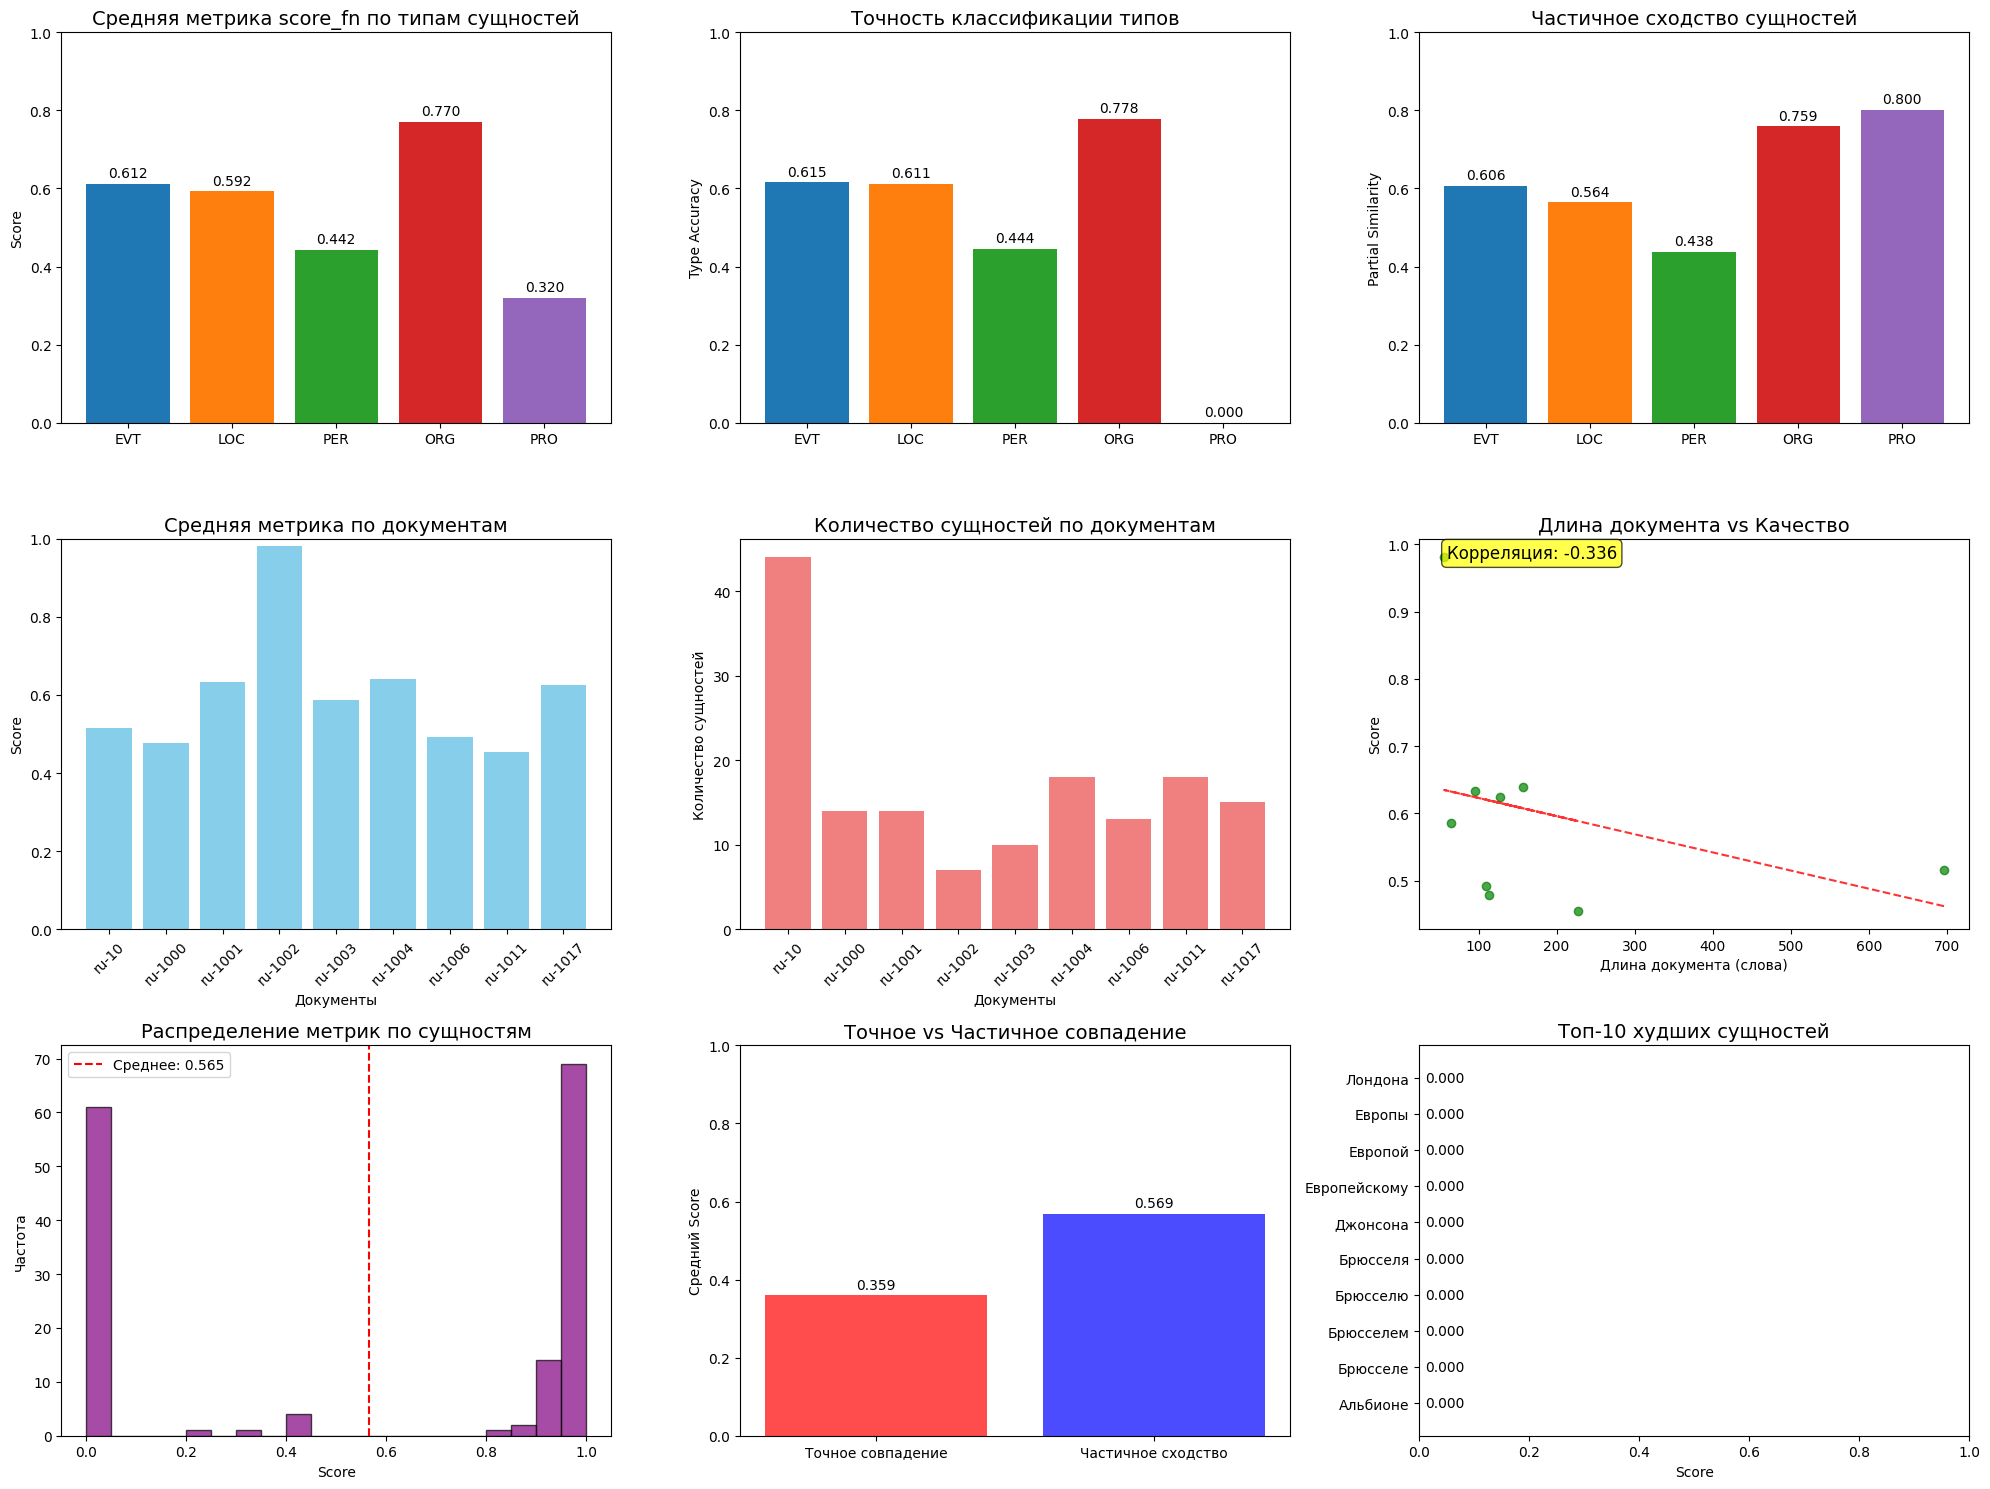

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

def analyze_metrics_by_entity_and_document(df: pd.DataFrame) -> dict:
    """
    Анализ метрик по сущностям и документам
    
    Returns:
        dict: результаты анализа с метриками по сущностям и документам
    """
    results = {
        'by_entity': defaultdict(list),
        'by_document': defaultdict(list),
        'by_entity_type': defaultdict(list)
    }
    
    # Вычисляем метрики для каждой строки
    df = df.copy()
    
    def combine_entity_type(entity, entity_type):
        if pd.isna(entity) or pd.isna(entity_type):
            return None
        return f"{entity}|{entity_type}"
    
    df['gold_combined'] = df.apply(lambda row: combine_entity_type(row['entity'], row['gold_answer']), axis=1)
    df['pred_combined'] = df.apply(lambda row: combine_entity_type(row['llm_entity'], row['llm_answer']), axis=1)
    
    # Вычисляем метрики для каждой строки
    df['exact_match'] = df.apply(lambda row: NERMetrics.exact_match_score(row['gold_combined'], row['pred_combined']), axis=1)
    df['boundary_match'] = df.apply(lambda row: NERMetrics.boundary_match_score(row['gold_combined'], row['pred_combined']), axis=1)
    df['partial_similarity'] = df.apply(lambda row: NERMetrics.partial_match_levenshtein(row['gold_combined'], row['pred_combined']), axis=1)
    df['type_accuracy'] = df.apply(lambda row: NERMetrics.type_accuracy_score(row['gold_combined'], row['pred_combined']), axis=1)
    df['score_fn_result'] = df.apply(lambda row: NERMetrics.score_fn(row['gold_combined'], row['pred_combined']), axis=1)
    
    # Анализ по сущностям (только там, где есть gold entity)
    gold_entities_mask = df['entity'].notna()
    for _, row in df[gold_entities_mask].iterrows():
        entity = row['entity']
        results['by_entity'][entity].append({
            'exact_match': row['exact_match'],
            'boundary_match': row['boundary_match'],
            'partial_similarity': row['partial_similarity'],
            'type_accuracy': row['type_accuracy'],
            'score_fn': row['score_fn_result'],
            'document_id': row['document_id']
        })
    
    # Анализ по типам сущностей
    for _, row in df[gold_entities_mask].iterrows():
        entity_type = row['gold_answer']
        if pd.notna(entity_type):
            results['by_entity_type'][entity_type].append({
                'exact_match': row['exact_match'],
                'boundary_match': row['boundary_match'],
                'partial_similarity': row['partial_similarity'],
                'type_accuracy': row['type_accuracy'],
                'score_fn': row['score_fn_result'],
                'entity': row['entity']
            })
    
    # Анализ по документам
    for doc_id in df['document_id'].unique():
        doc_data = df[df['document_id'] == doc_id]
        doc_gold_mask = doc_data['entity'].notna()
        
        if doc_gold_mask.sum() > 0:  # Если в документе есть золотые сущности
            results['by_document'][doc_id] = {
                'exact_match_avg': doc_data[doc_gold_mask]['exact_match'].mean(),
                'boundary_match_avg': doc_data[doc_gold_mask]['boundary_match'].mean(),
                'partial_similarity_avg': doc_data[doc_gold_mask]['partial_similarity'].mean(),
                'type_accuracy_avg': doc_data[doc_gold_mask]['type_accuracy'].mean(),
                'score_fn_avg': doc_data[doc_gold_mask]['score_fn_result'].mean(),
                'total_entities': doc_gold_mask.sum(),
                'document_length': len(doc_data.iloc[0]['document_text'].split()) if len(doc_data) > 0 else 0
            }
    
    return results, df

def plot_metrics_analysis(results: dict):
    """
    Построение графиков анализа метрик
    """
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Метрики по типам сущностей
    plt.subplot(3, 3, 1)
    entity_types = list(results['by_entity_type'].keys())
    avg_scores = []
    
    for entity_type in entity_types:
        type_data = results['by_entity_type'][entity_type]
        avg_score = np.mean([item['score_fn'] for item in type_data])
        avg_scores.append(avg_score)
    
    bars = plt.bar(entity_types, avg_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    plt.title('Средняя метрика score_fn по типам сущностей', fontsize=14)
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Добавляем значения на столбцы
    for bar, score in zip(bars, avg_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 2. Точность типов по типам сущностей
    plt.subplot(3, 3, 2)
    type_accuracy_scores = []
    
    for entity_type in entity_types:
        type_data = results['by_entity_type'][entity_type]
        avg_type_acc = np.mean([item['type_accuracy'] for item in type_data])
        type_accuracy_scores.append(avg_type_acc)
    
    bars = plt.bar(entity_types, type_accuracy_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    plt.title('Точность классификации типов', fontsize=14)
    plt.ylabel('Type Accuracy')
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, type_accuracy_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 3. Частичное сходство по типам сущностей
    plt.subplot(3, 3, 3)
    partial_scores = []
    
    for entity_type in entity_types:
        type_data = results['by_entity_type'][entity_type]
        avg_partial = np.mean([item['partial_similarity'] for item in type_data])
        partial_scores.append(avg_partial)
    
    bars = plt.bar(entity_types, partial_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
    plt.title('Частичное сходство сущностей', fontsize=14)
    plt.ylabel('Partial Similarity')
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, partial_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 4. Метрики по документам
    plt.subplot(3, 3, 4)
    doc_ids = list(results['by_document'].keys())
    doc_scores = [results['by_document'][doc]['score_fn_avg'] for doc in doc_ids]
    
    bars = plt.bar(range(len(doc_ids)), doc_scores, color='skyblue')
    plt.title('Средняя метрика по документам', fontsize=14)
    plt.xlabel('Документы')
    plt.ylabel('Score')
    plt.xticks(range(len(doc_ids)), doc_ids, rotation=45)
    plt.ylim(0, 1)
    
    # 5. Количество сущностей по документам
    plt.subplot(3, 3, 5)
    entity_counts = [results['by_document'][doc]['total_entities'] for doc in doc_ids]
    
    bars = plt.bar(range(len(doc_ids)), entity_counts, color='lightcoral')
    plt.title('Количество сущностей по документам', fontsize=14)
    plt.xlabel('Документы')
    plt.ylabel('Количество сущностей')
    plt.xticks(range(len(doc_ids)), doc_ids, rotation=45)
    
    # 6. Корреляция длины документа и качества
    plt.subplot(3, 3, 6)
    doc_lengths = [results['by_document'][doc]['document_length'] for doc in doc_ids]
    
    plt.scatter(doc_lengths, doc_scores, color='green', alpha=0.7)
    plt.title('Длина документа vs Качество', fontsize=14)
    plt.xlabel('Длина документа (слова)')
    plt.ylabel('Score')
    
    # Добавляем линию тренда
    z = np.polyfit(doc_lengths, doc_scores, 1)
    p = np.poly1d(z)
    plt.plot(doc_lengths, p(doc_lengths), "r--", alpha=0.8)
    
    # Вычисляем корреляцию
    correlation = np.corrcoef(doc_lengths, doc_scores)[0, 1]
    plt.text(0.05, 0.95, f'Корреляция: {correlation:.3f}', 
             transform=plt.gca().transAxes, fontsize=12, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 7. Распределение метрик по всем сущностям
    plt.subplot(3, 3, 7)
    all_scores = []
    for entity_data in results['by_entity'].values():
        all_scores.extend([item['score_fn'] for item in entity_data])
    
    plt.hist(all_scores, bins=20, color='purple', alpha=0.7, edgecolor='black')
    plt.title('Распределение метрик по сущностям', fontsize=14)
    plt.xlabel('Score')
    plt.ylabel('Частота')
    plt.axvline(np.mean(all_scores), color='red', linestyle='--', 
                label=f'Среднее: {np.mean(all_scores):.3f}')
    plt.legend()
    
    # 8. Сравнение точного и частичного совпадения
    plt.subplot(3, 3, 8)
    exact_scores = []
    partial_scores_for_comparison = []
    
    for entity_data in results['by_entity'].values():
        exact_scores.extend([item['exact_match'] for item in entity_data])
        partial_scores_for_comparison.extend([item['partial_similarity'] for item in entity_data])
    
    x = ['Точное совпадение', 'Частичное сходство']
    y = [np.mean(exact_scores), np.mean(partial_scores_for_comparison)]
    
    bars = plt.bar(x, y, color=['red', 'blue'], alpha=0.7)
    plt.title('Точное vs Частичное совпадение', fontsize=14)
    plt.ylabel('Средний Score')
    plt.ylim(0, 1)
    
    for bar, score in zip(bars, y):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # 9. Топ-10 худших сущностей
    plt.subplot(3, 3, 9)
    entity_avg_scores = {}
    for entity, entity_data in results['by_entity'].items():
        avg_score = np.mean([item['score_fn'] for item in entity_data])
        entity_avg_scores[entity] = avg_score
    
    # Сортируем по возрастанию и берем топ-10 худших
    worst_entities = sorted(entity_avg_scores.items(), key=lambda x: x[1])[:10]
    
    if worst_entities:
        entities, scores = zip(*worst_entities)
        bars = plt.barh(range(len(entities)), scores, color='orange')
        plt.title('Топ-10 худших сущностей', fontsize=14)
        plt.xlabel('Score')
        plt.yticks(range(len(entities)), entities)
        plt.xlim(0, 1)
        
        # Добавляем значения
        for i, (bar, score) in enumerate(zip(bars, scores)):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{score:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

def print_detailed_analysis(results: dict):
    """
    Выводит детальный анализ результатов
    """
    print("="*80)
    print("ДЕТАЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*80)
    
    # Анализ по типам сущностей
    print("\n1. АНАЛИЗ ПО ТИПАМ СУЩНОСТЕЙ:")
    print("-" * 50)
    
    for entity_type, type_data in results['by_entity_type'].items():
        scores = [item['score_fn'] for item in type_data]
        type_acc = [item['type_accuracy'] for item in type_data]
        partial_sim = [item['partial_similarity'] for item in type_data]
        
        print(f"\n{entity_type}:")
        print(f"  Количество сущностей: {len(type_data)}")
        print(f"  Средняя метрика: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
        print(f"  Точность типа: {np.mean(type_acc):.3f}")
        print(f"  Частичное сходство: {np.mean(partial_sim):.3f}")
    
    # Анализ по документам
    print("\n\n2. АНАЛИЗ ПО ДОКУМЕНТАМ:")
    print("-" * 50)
    
    for doc_id, doc_data in results['by_document'].items():
        print(f"\n{doc_id}:")
        print(f"  Средняя метрика: {doc_data['score_fn_avg']:.3f}")
        print(f"  Количество сущностей: {doc_data['total_entities']}")
        print(f"  Длина документа: {doc_data['document_length']} слов")
        print(f"  Точность типов: {doc_data['type_accuracy_avg']:.3f}")
    
    # Общая статистика
    print("\n\n3. ОБЩАЯ СТАТИСТИКА:")
    print("-" * 50)
    
    all_scores = []
    for entity_data in results['by_entity'].values():
        all_scores.extend([item['sаcore_fn'] for item in entity_data])
    
    print(f"Общее количество сущностей: {len(all_scores)}")
    print(f"Средняя метрика: {np.mean(all_scores):.3f}")
    print(f"Медианная метрика: {np.median(all_scores):.3f}")
    print(f"Стандартное отклонение: {np.std(all_scores):.3f}")
    print(f"Процент точных совпадений: {np.mean([s == 1.0 for s in all_scores]) * 100:.1f}%")
    print(f"Процент полных провалов: {np.mean([s == 0.0 for s in all_scores]) * 100:.1f}%")

# Применяем анализ к данным
results, enhanced_df = analyze_metrics_by_entity_and_document(results_df)
print_detailed_analysis(results)
plot_metrics_analysis(results)